In [2]:
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64

HOST = 'localhost'
PORT = 27010

# Load Dataset

def get_histo(img):
    gray = img.convert('L')

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_axis_off()
    ax.plot(gray.histogram())
    img_byte_array = io.BytesIO()
    fig.savefig(img_byte_array, format='jpeg')
    plt.close(fig)
    return base64.b64encode(img_byte_array.getvalue()).decode()


random.seed(1)

mongo_info = MongoInfo(host=HOST, port=PORT)
thumb_list = []
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    print(size)
    for i in range(50):
        idx = int(random.random()*size)
        thumb = thumb_api.read(idx)
        thumb_list.append(thumb)
    #plt.imshow(thumb)
    

451



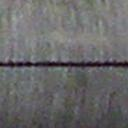
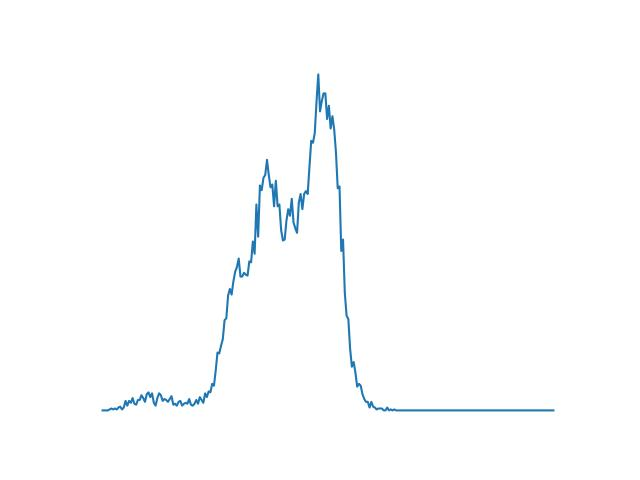
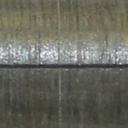
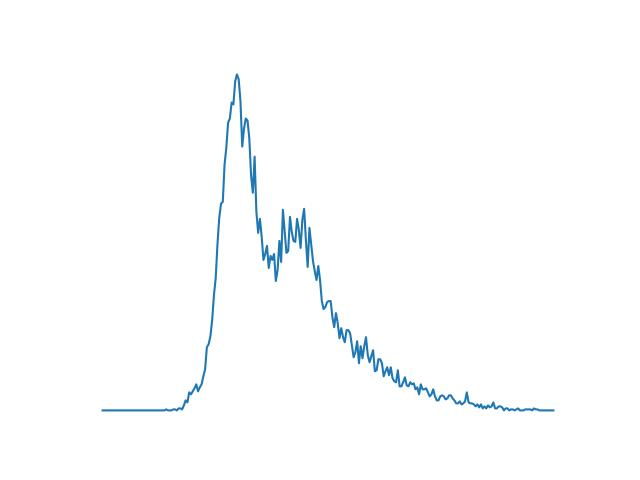
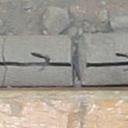
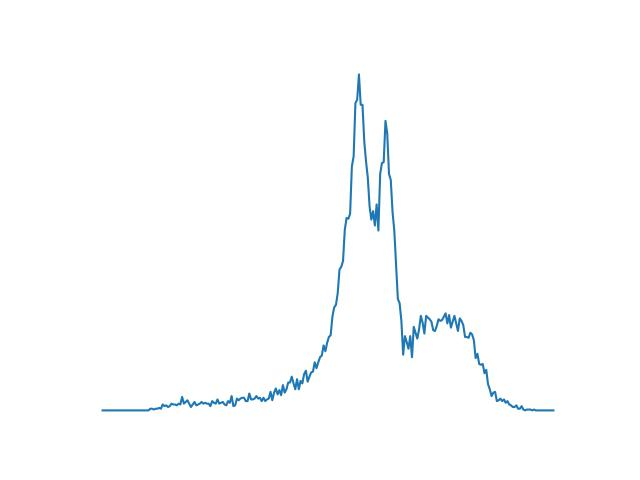
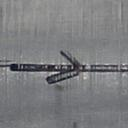
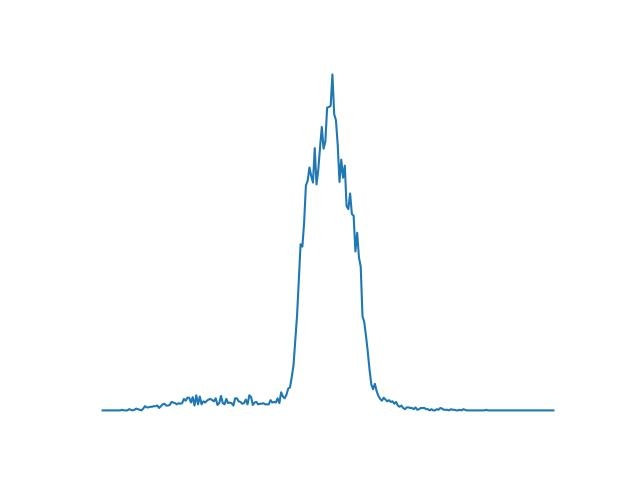
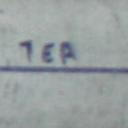
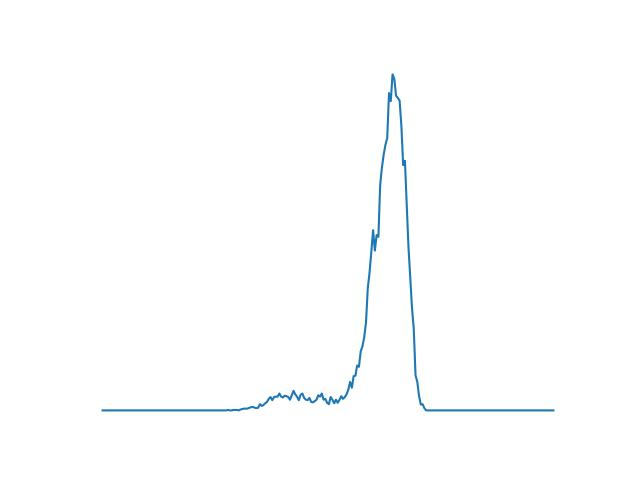
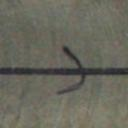
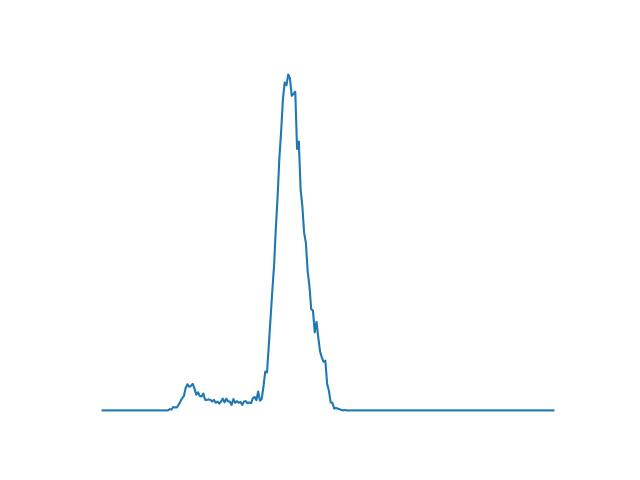
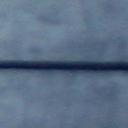
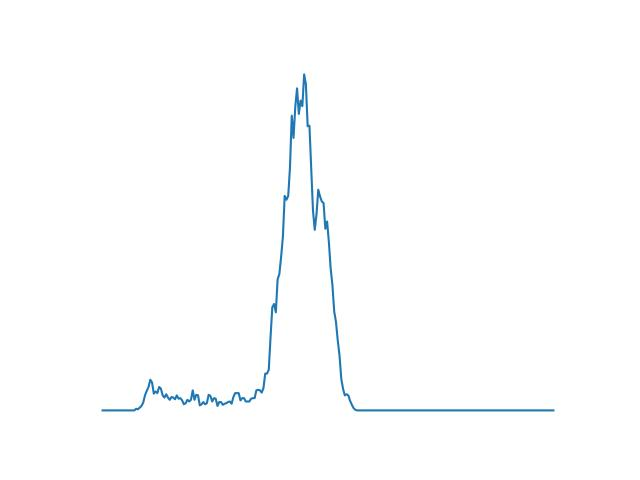
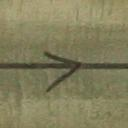
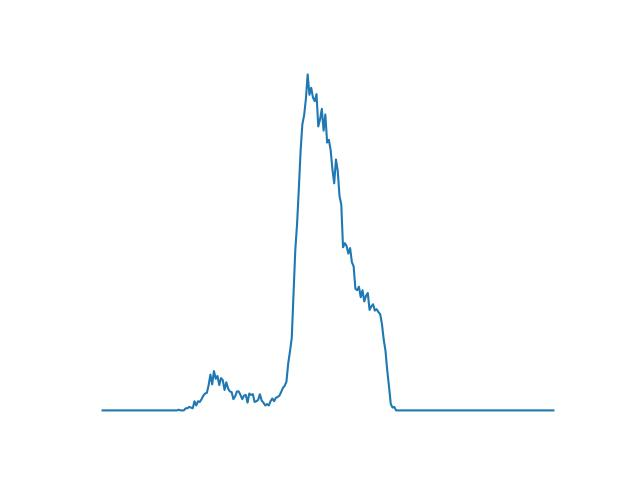
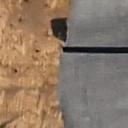
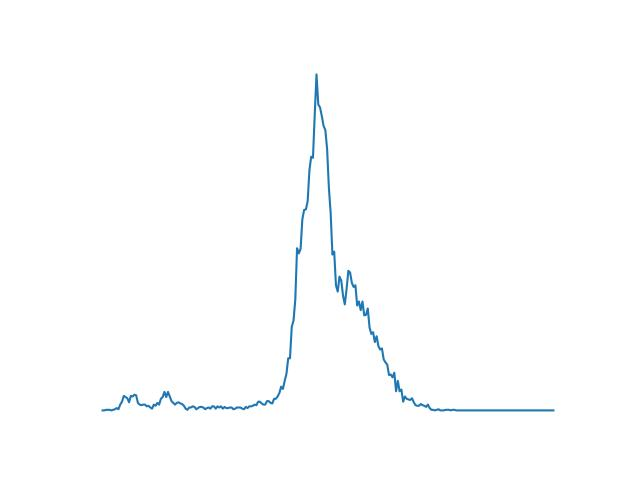
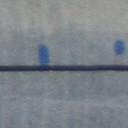
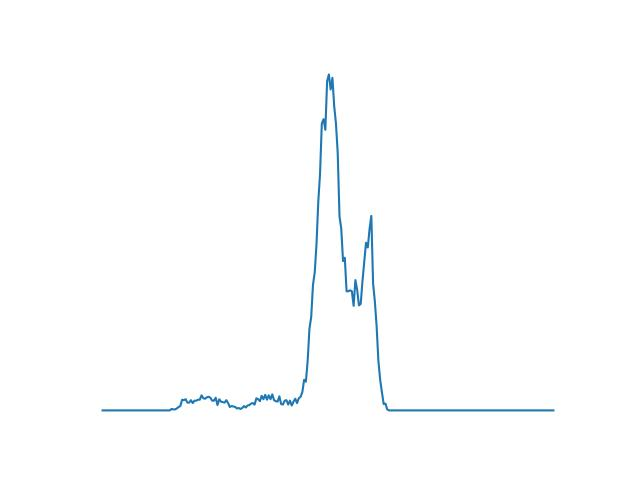
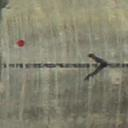
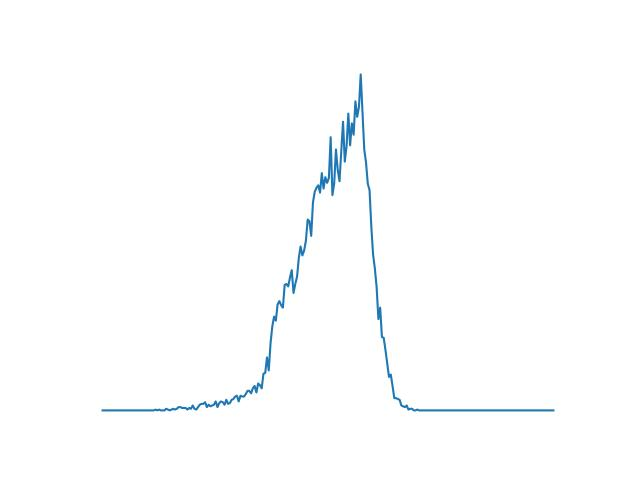
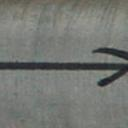
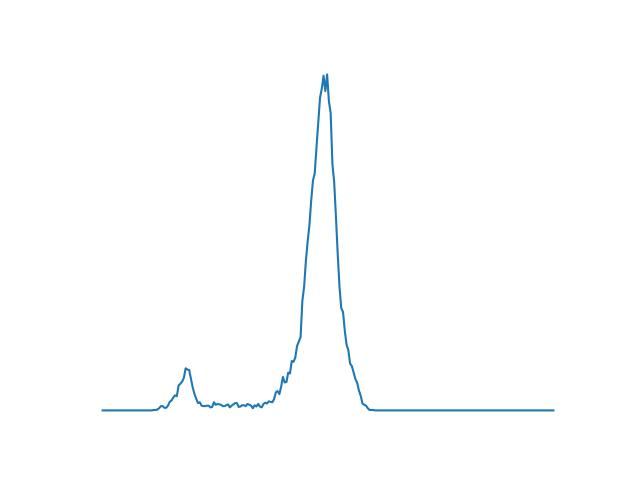
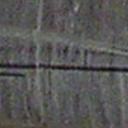
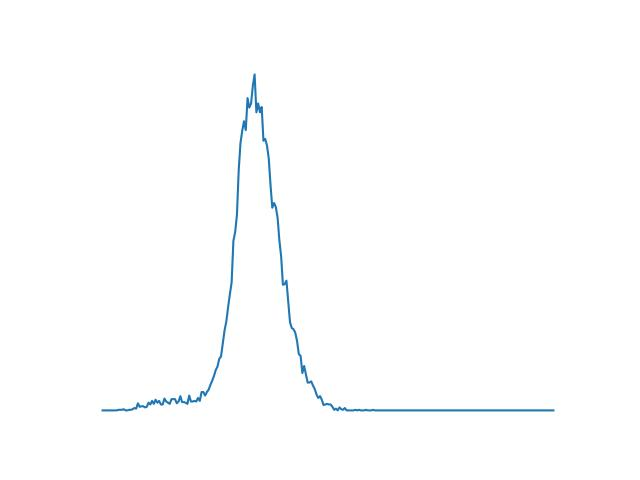
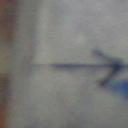
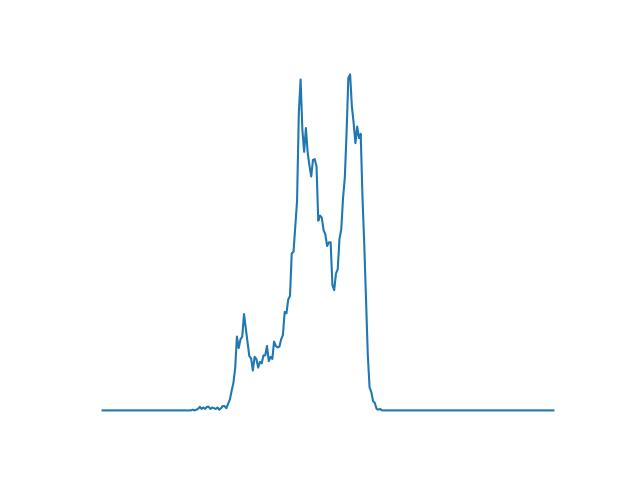
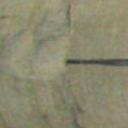
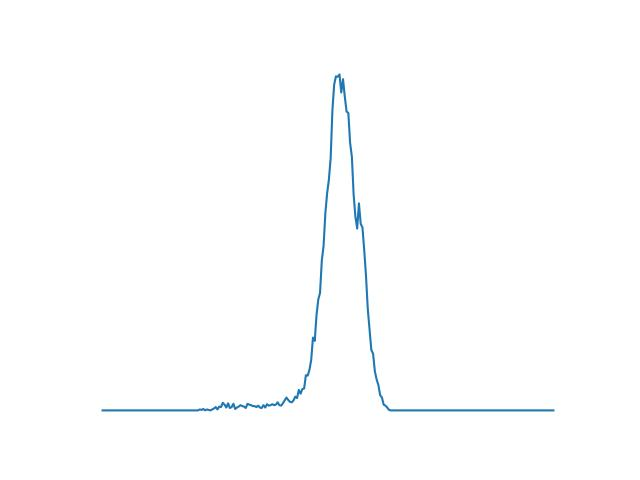
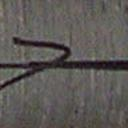
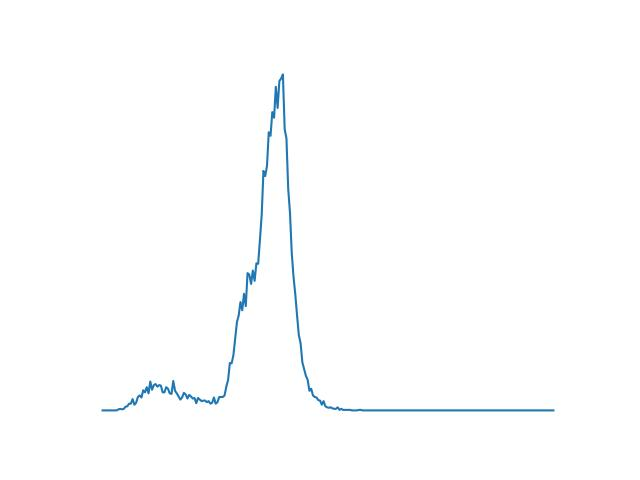
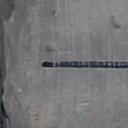
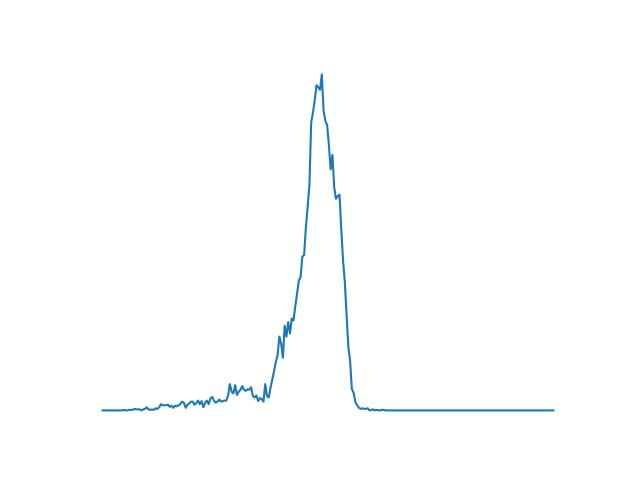
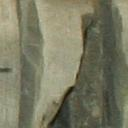
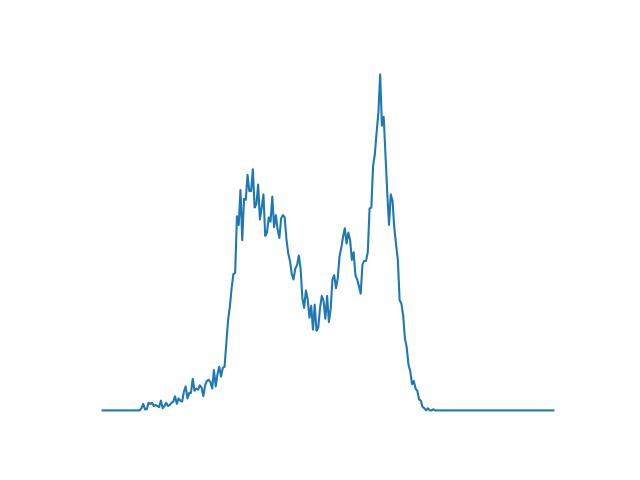
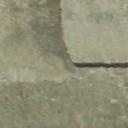
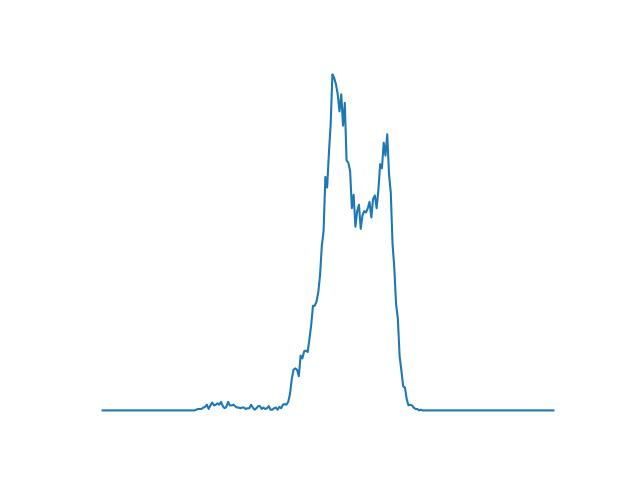
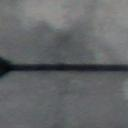
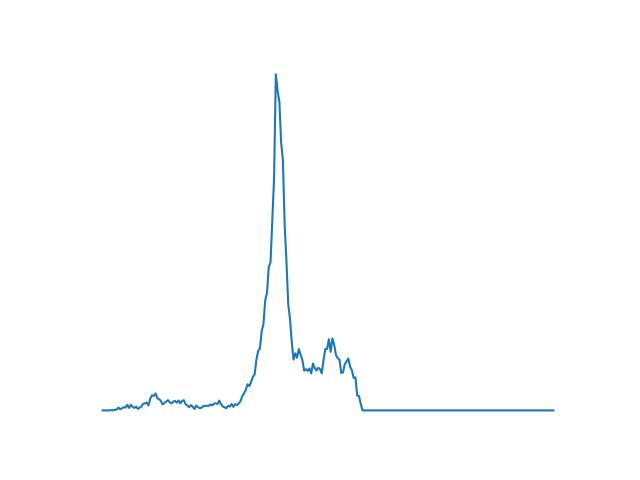
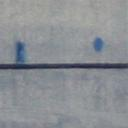
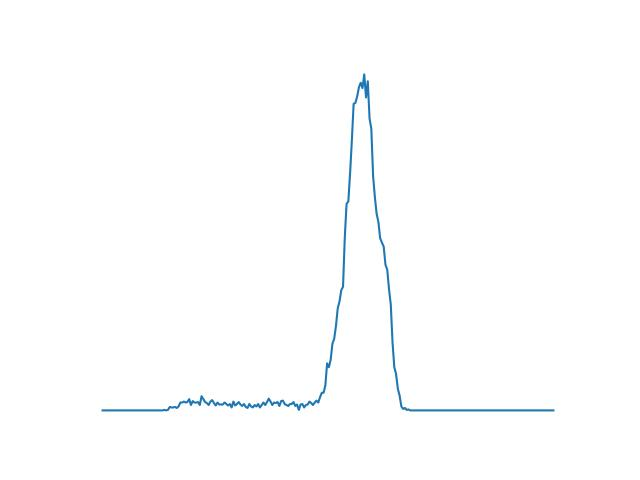
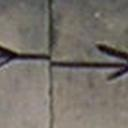
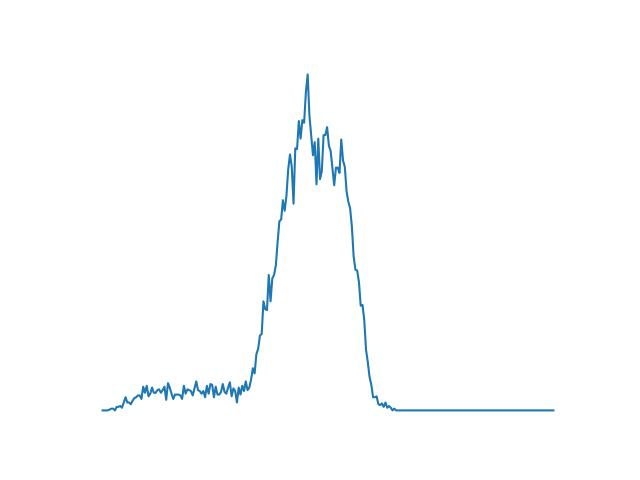
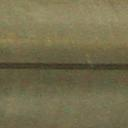
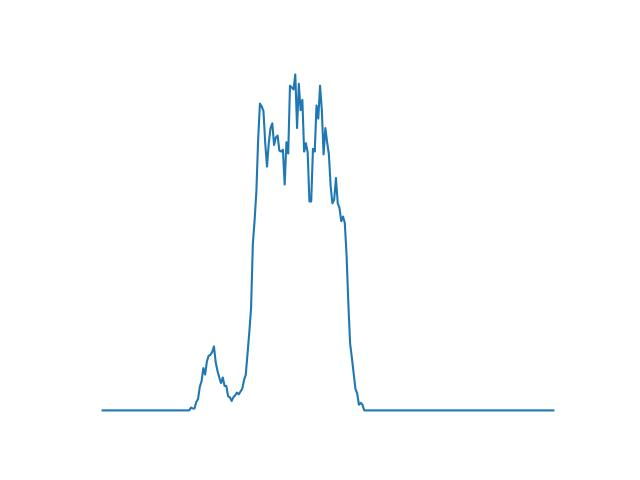
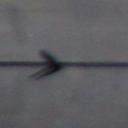
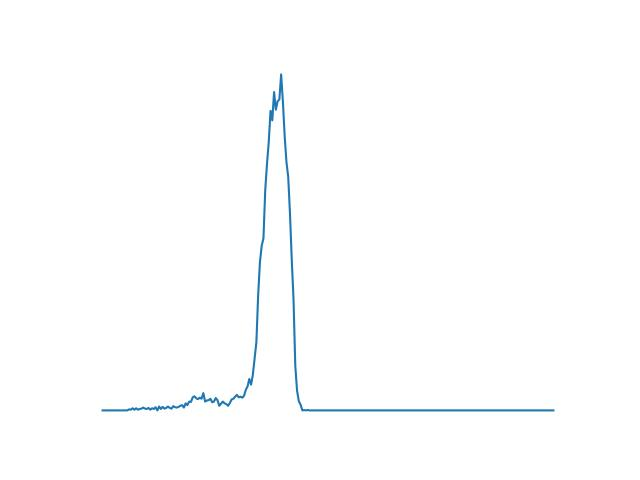
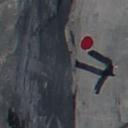
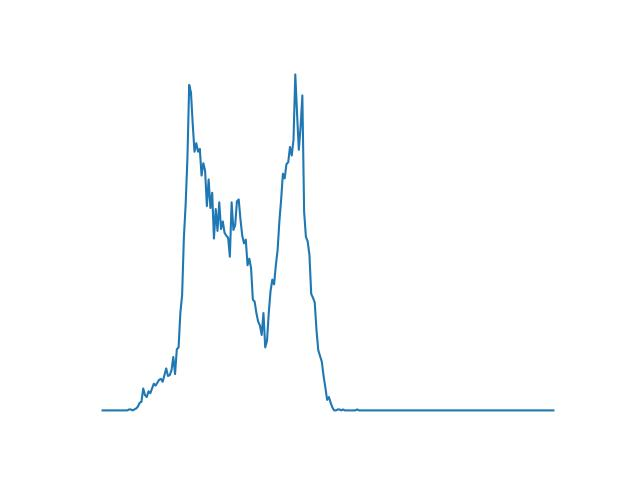
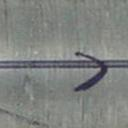
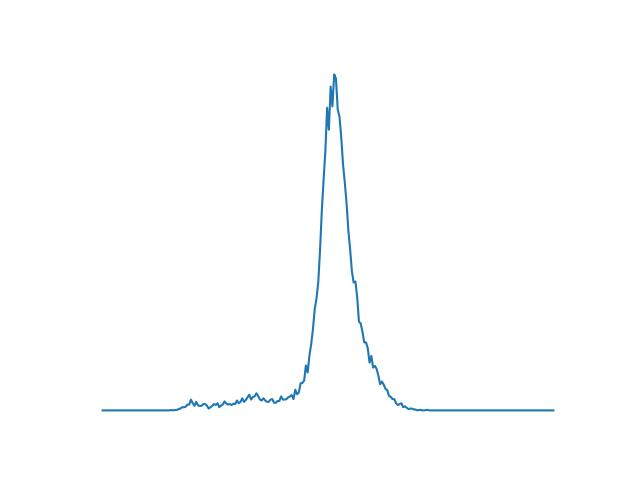
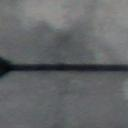
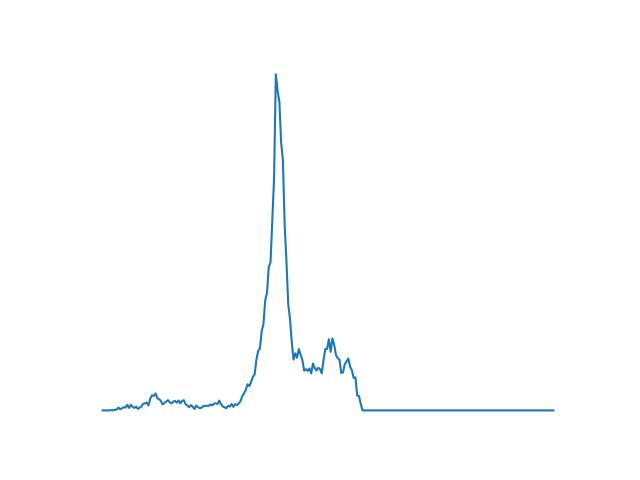
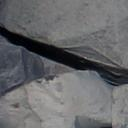
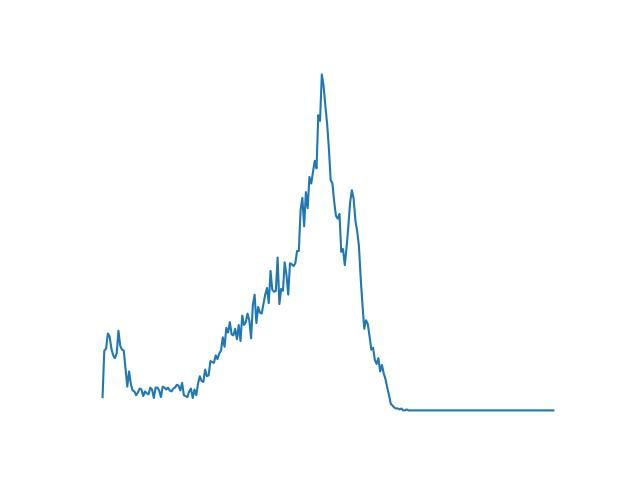
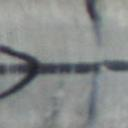
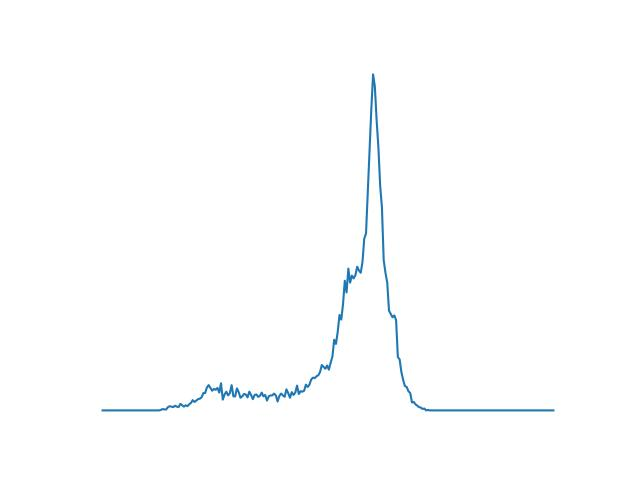
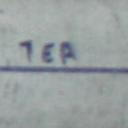
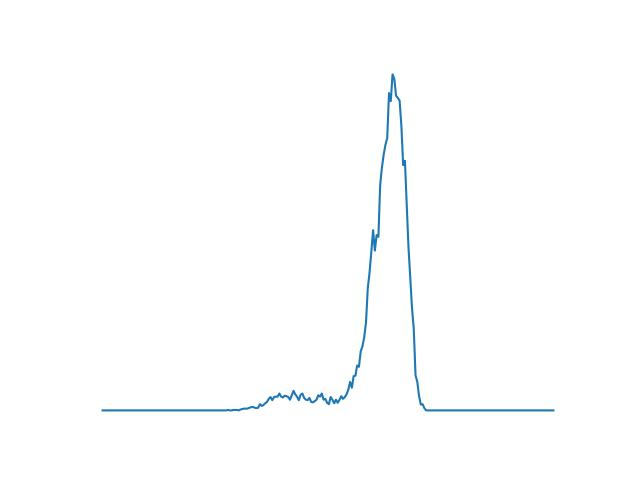
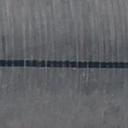
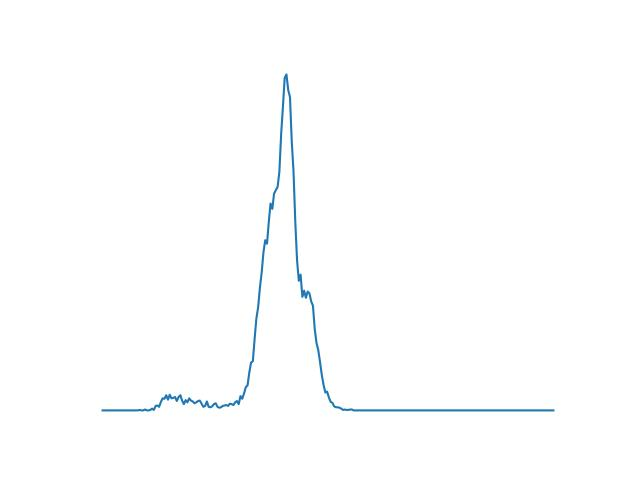
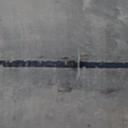
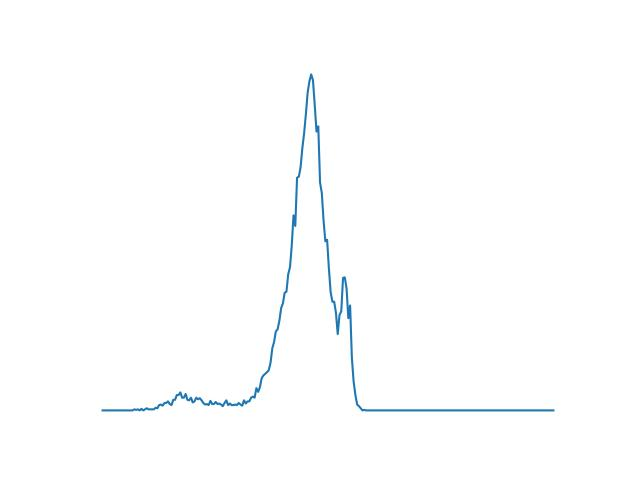
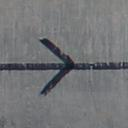
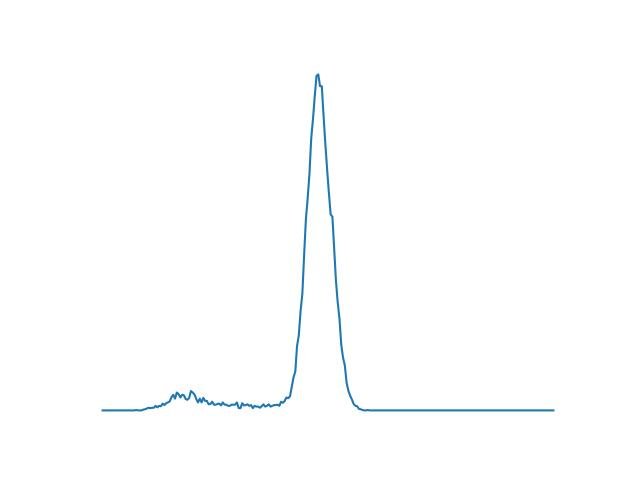
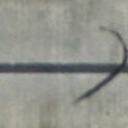
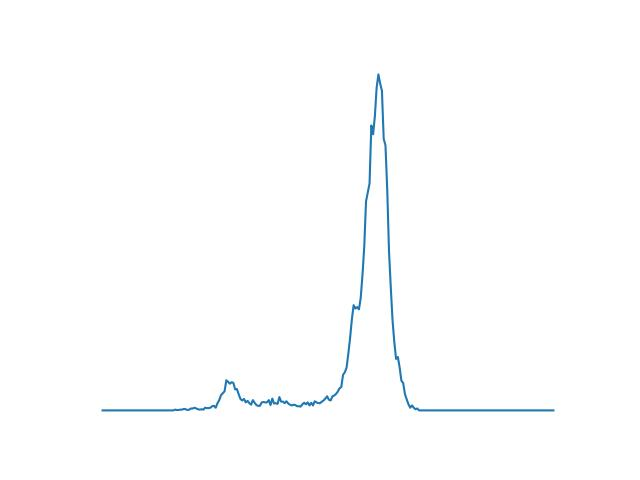
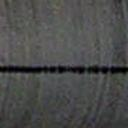
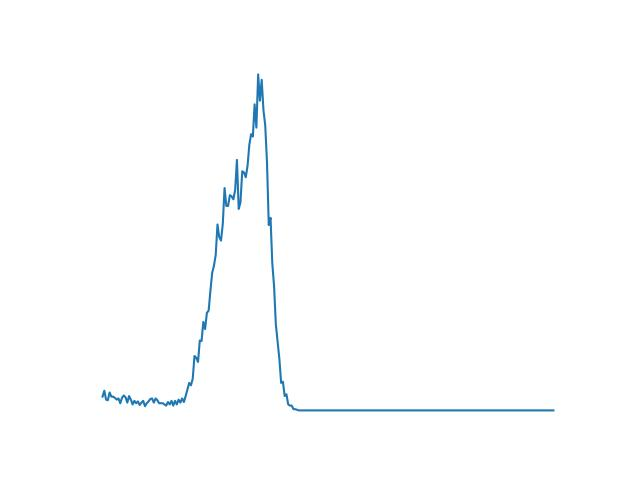
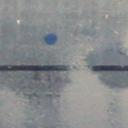
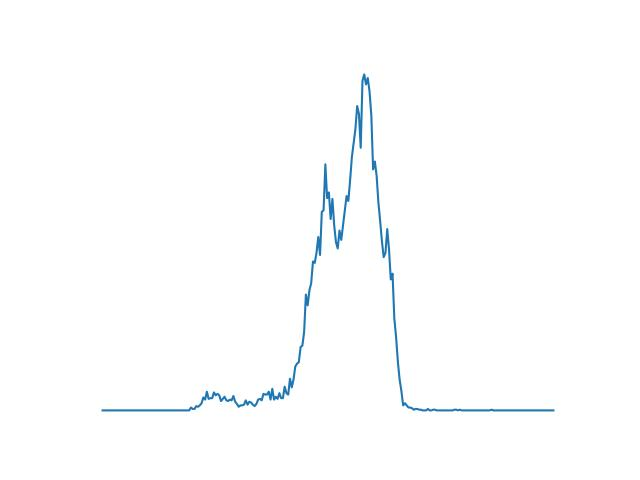
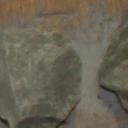
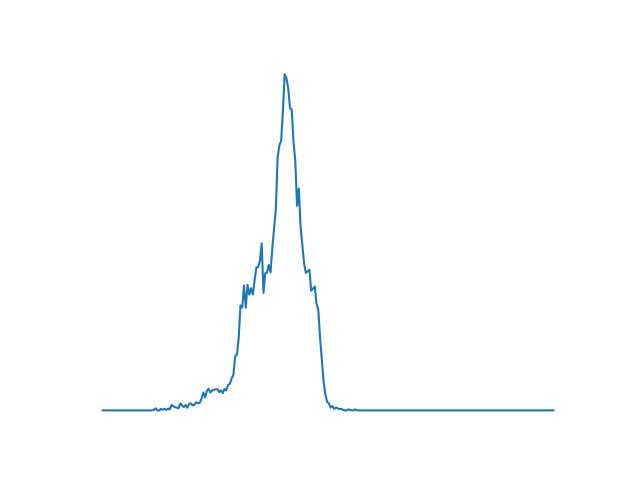
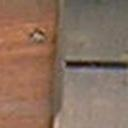
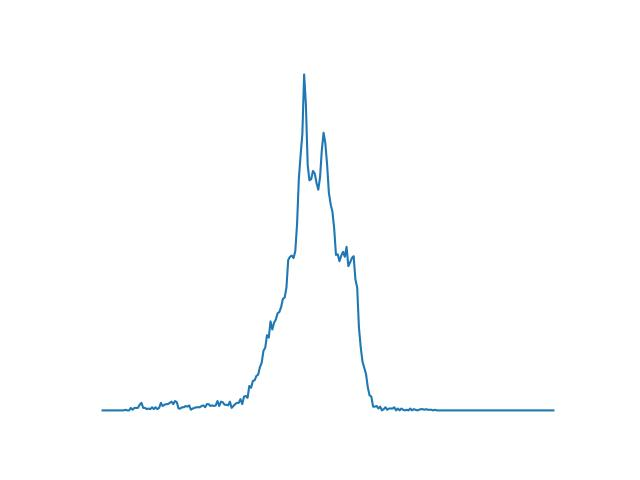
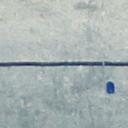
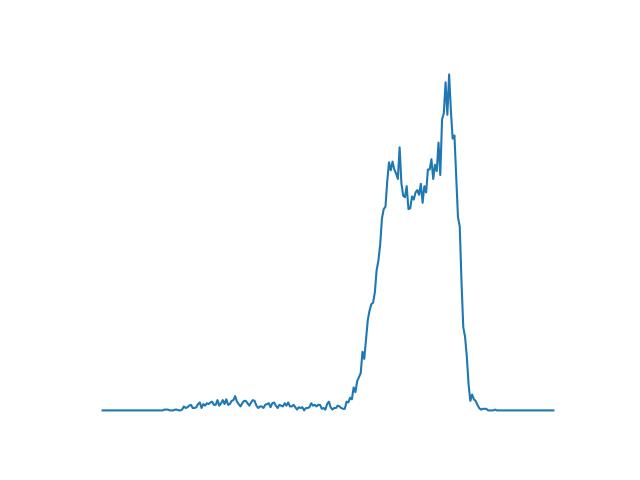
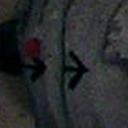
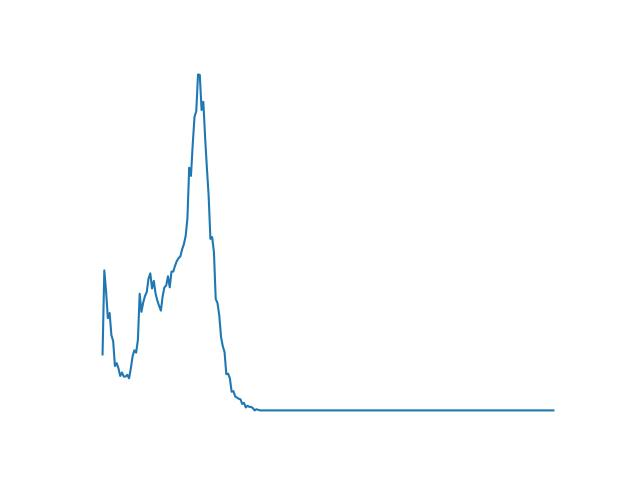
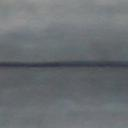
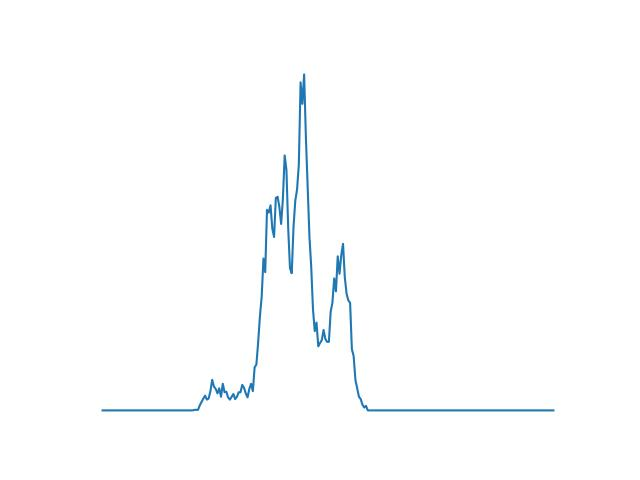
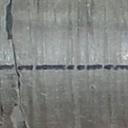
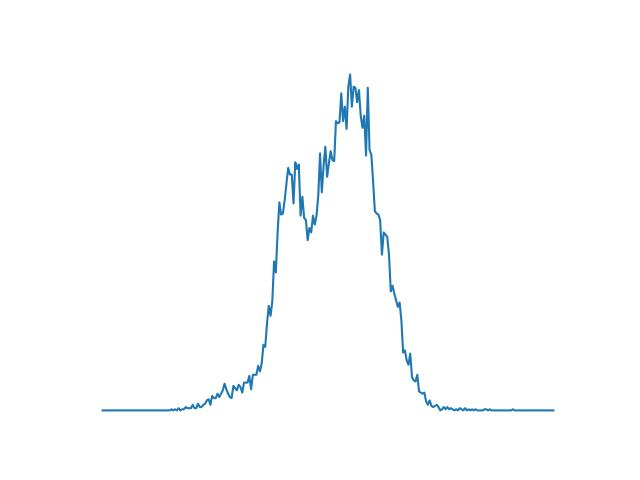
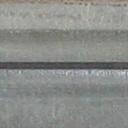
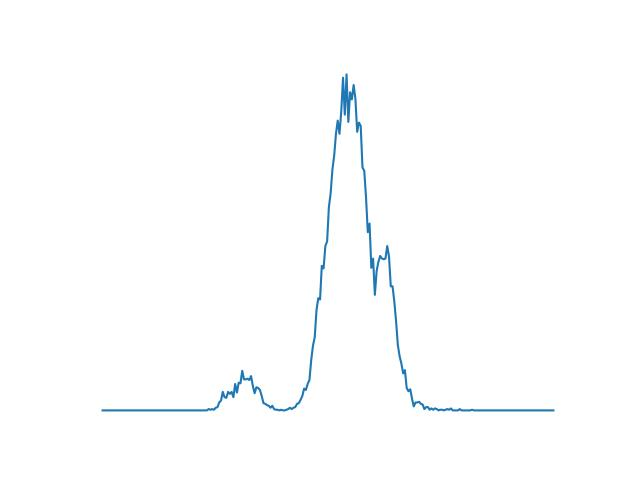
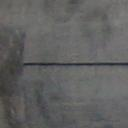
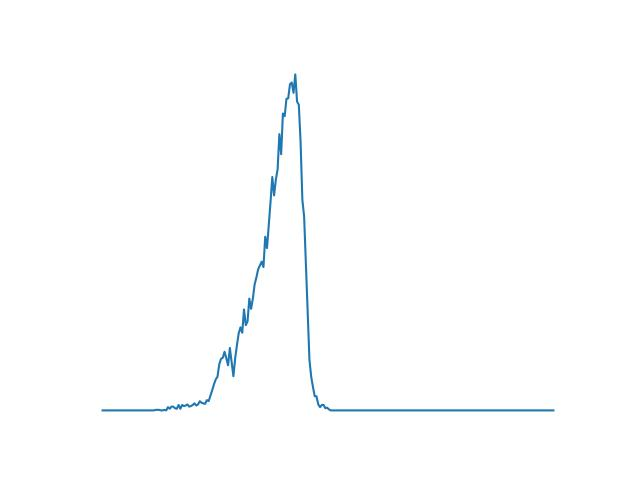
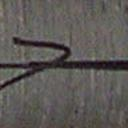
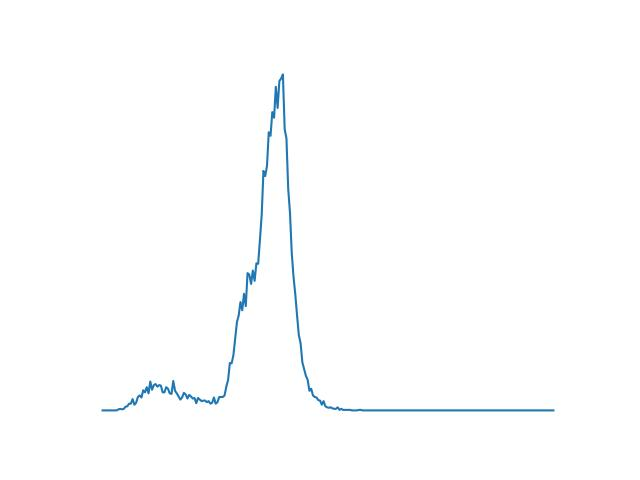
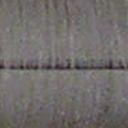
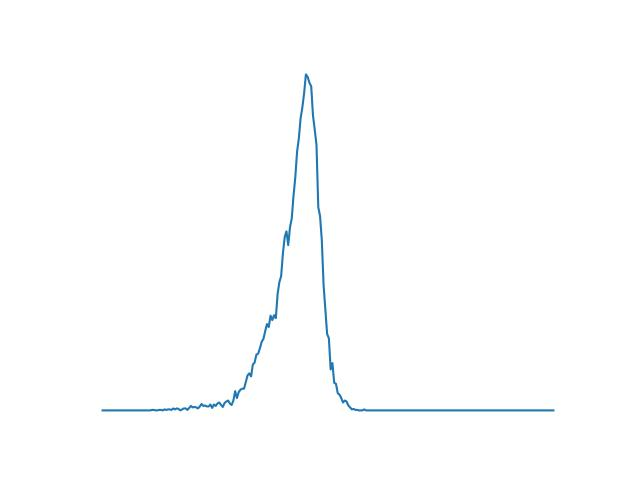
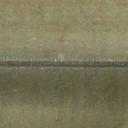
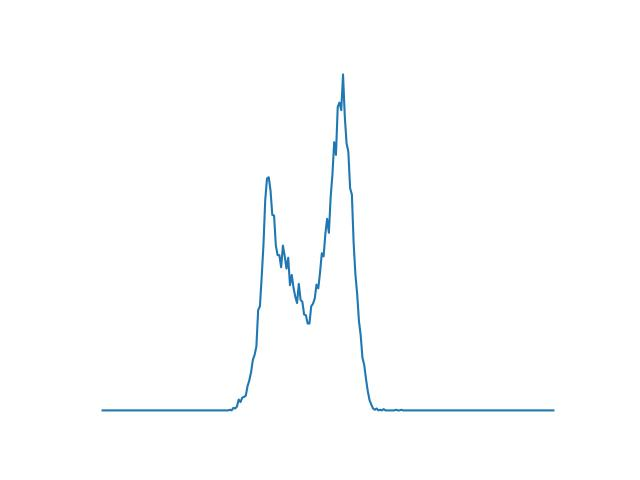
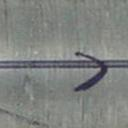
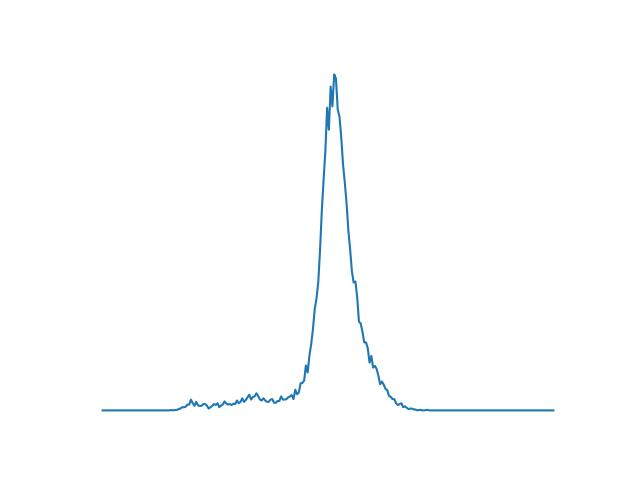
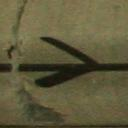
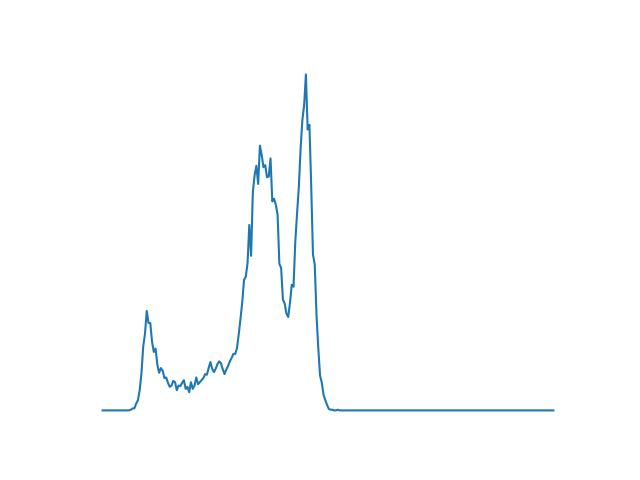
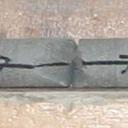
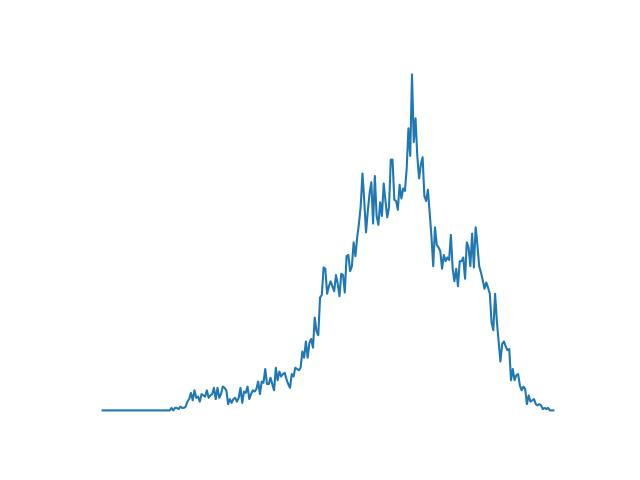

In [5]:
from IPython.display import Image, HTML, display

def to_base64(img: Image):
    byte_array = io.BytesIO()
    img.save(byte_array, format='jpeg')
    return base64.b64encode(byte_array.getvalue()).decode()

html_str = "<div style='display: inline-block; align:justify; border: 1px solid white;'>"
html_str +="<img style='width: 128px; margin: 0px; float: left; ' src='data:image/jpg;base64,%s' />"
html_str +="<img style='width: 128px; margin: 0px; float: left; 'src='data:image/jpg;base64,%s' />"
html_str +="<P style='text-align: center;'>%s (%s)</P>"
html_str +="</div>"

imagesList=''.join( [ html_str % (
    to_base64(t.jpg), 
    get_histo(t.jpg), 
    t.measurement.val_1m, 
    t.measurement.image_id) for t in thumb_list ]
    )
display(HTML(imagesList))



### Création d'un DataFrame pandas

In [3]:
import pandas as pd
import numpy as np
from calcimetry.thumbnail_api import ThumbnailAPI

n_bins = 6
def get_histo(t, n_bins):
    w, h = t.jpg.size
    histo, bins = np.histogram(t.jpg, bins=n_bins)
    return histo.astype(np.float64) / (w*h)

#create dataframe for learing
columns = [
    "focus", "mean_grad", "mean_color", "brisque"
]
for i in range(n_bins):
    columns.append(f"bin_{i}")
columns.append('target')
    
data = []

with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()    
    for idx in range(size):
        idx = int(random.random()*size)
        t = thumb_api.read(idx)
        row = [t.quality.focus, t.quality.gradient['ave'], np.mean(t.quality.colours), t.quality.brisque]
        histo = get_histo(t, n_bins)
        for i in range(n_bins):
            row.append(histo[i])
        row.append(float(t.measurement.val_1m))
        data.append(row)
    
df = pd.DataFrame(data, columns=columns)
df.head()

,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,87.712774,45.753823,68.818755,36.284851,0.127014,0.470398,0.578857,1.018066,0.789429,0.016235,21.0
1,26.751848,17.619666,121.860714,27.310730,0.002625,0.426270,1.073608,0.860474,0.401306,0.235718,51.0
2,248.949246,45.428831,119.675439,39.584167,0.008728,0.040405,0.602600,1.665527,0.652588,0.030151,48.0
3,267.779012,46.967758,150.376659,32.961609,0.027466,0.095337,1.711365,1.084900,0.076599,0.004333,24.0
4,35.922316,31.578210,111.285971,37.866394,0.071411,0.081177,0.098450,1.175964,1.306641,0.266357,31.0


Normalisons les variables d'entrées $z_i=(x_i-\mu_i)/\sigma_i$

In [4]:
for c in columns:
    if c == 'target':
        continue
    mean = df[c].mean()
    std = df[c].std()
    df[c] = (df[c] - mean) / std 

df.head()

,focus,mean_grad,mean_color,brisque,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,target
0,-0.140179,0.997513,-1.089952,0.245002,0.442587,0.936647,0.064628,0.156184,-0.262873,-0.644091,21.0
1,-0.747494,-1.351305,0.827319,-0.631640,-0.545656,0.770205,1.174080,-0.176841,-0.902517,-0.072363,51.0
2,1.466116,0.970381,0.748329,0.567298,-0.497166,-0.685188,0.117870,1.524400,-0.488393,-0.607841,48.0
3,1.653705,1.098860,1.858064,-0.079630,-0.348299,-0.477998,2.604213,0.297417,-1.437649,-0.675094,24.0
4,-0.656134,-0.185957,0.445081,0.399496,0.000835,-0.531407,-1.012660,0.489855,0.589516,0.007450,31.0


Regardons un peu les corrélations entre les variables d'entrées

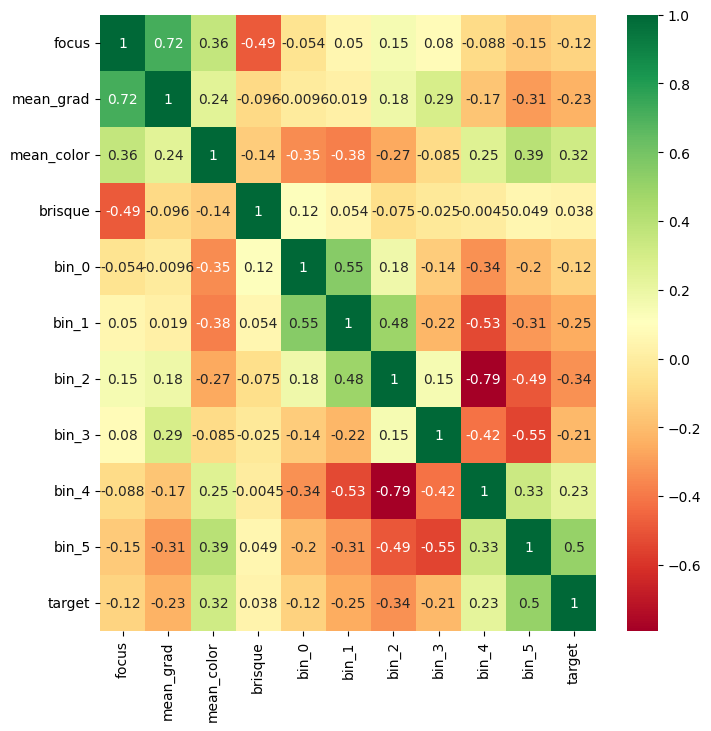

In [5]:
import seaborn as sns #visualization package
corr = df.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(corr,cmap= 'RdYlGn',annot=True)
plt.show()

- Positif: Aucune des variables $x_i$ d'entrées ne sont corrélées entre elles vraiment.
- Négatif: On voit aussi que la cible (target) n'est pas vraiment corrélées avec aucune des variables d'entrées

## Modélisation

1) On scinde en (features, target)

In [10]:
#independent variables / explanatory variables
x = df.drop(labels='target', axis=1)  #axis=1 means we drop data by column.
x = df[['mean_color']]

#dependent variable / response / target variable.
y = df['target']

2) On scinde en dataset d'apprentissage et de validation

In [11]:
from sklearn.model_selection import train_test_split
#splitting the dataset into 75%-25% train-test split 
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.10,random_state=999)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(405, 1)
(46, 1)
(405,)
(46,)


3) On réalise la régression

In [12]:
from sklearn.linear_model import BayesianRidge, LinearRegression, ARDRegression

def get_model(kind):
    return { 'ridge': BayesianRidge(), 'linear': LinearRegression(), "ard": ARDRegression() }[kind]
   

lm = get_model('linear')
lm.fit(train_x, train_y)

LinearRegression()

4) On évalue le modèle

In [13]:
predicted_y = lm.predict(test_x)

In [14]:
from sklearn import metrics as mt
print("1) The model explains,", np.round(mt.explained_variance_score(test_y,predicted_y)*100,2),"% variance of the target w.r.t features is")
print("2) The Mean Absolute Error of model is:", np.round(mt.mean_absolute_error(test_y,predicted_y ),2))
print("3) The R-Square score of the model is " , np.round(mt.r2_score(test_y,predicted_y),2))

1) The model explains, 5.06 % variance of the target w.r.t features is
2) The Mean Absolute Error of model is: 11.29
3) The R-Square score of the model is  0.05


Text(0, 0.5, 'predicted')

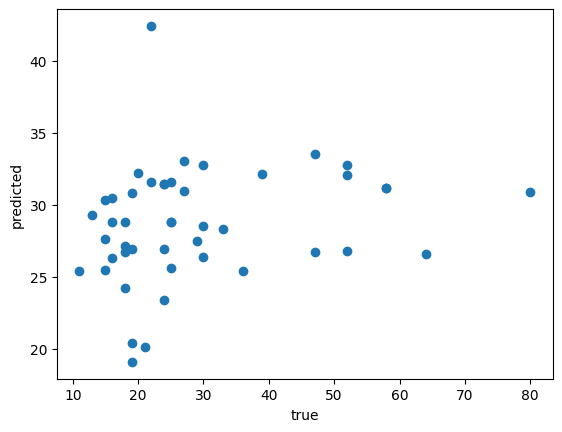

In [15]:
plt.scatter(test_y, predicted_y)
plt.xlabel('true')
plt.ylabel('predicted')